In [34]:
import pandas as pd

In [35]:
import os
import glob
path = os.getcwd() + '/threads/*.csv'
all_files = glob.glob(path)

In [36]:
df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)

In [37]:
# param cols
param_cols = list(filter(lambda x : 'Param:' in x, df.columns))
benchmarks = sorted(set(filter(lambda x : (not re.search(':', x)) or re.search('LLC-load-misses', x), df['Benchmark'])))

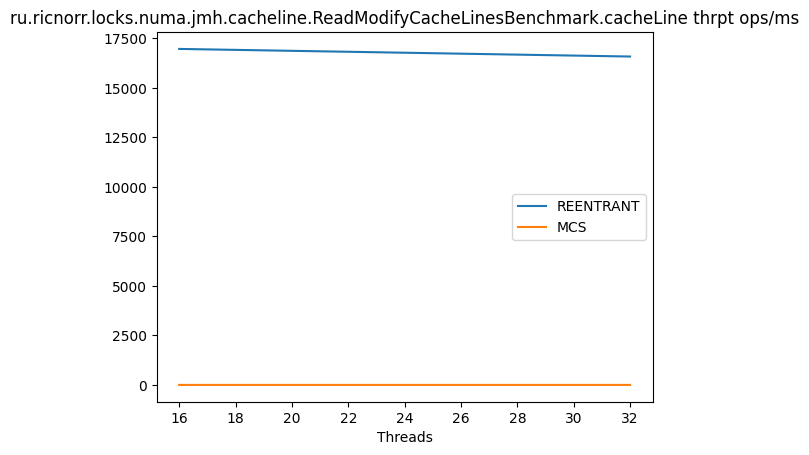

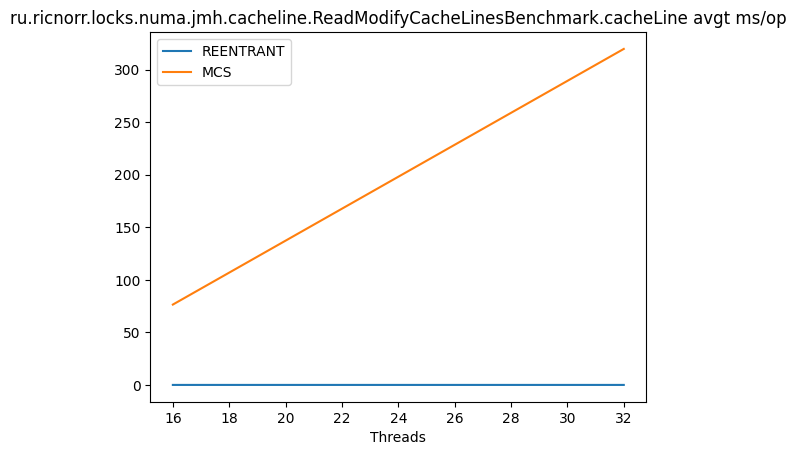

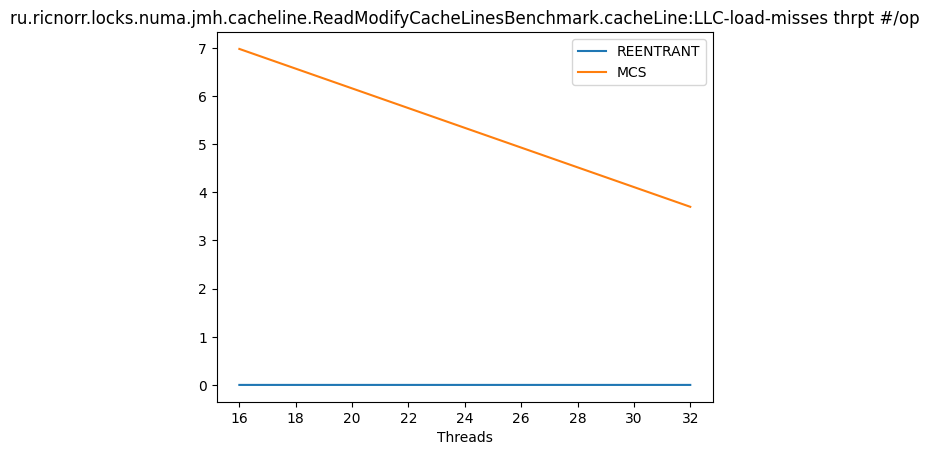

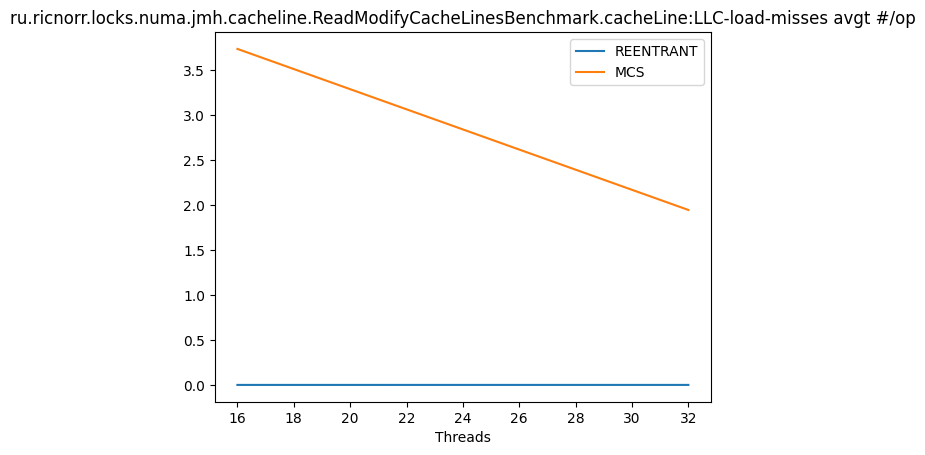

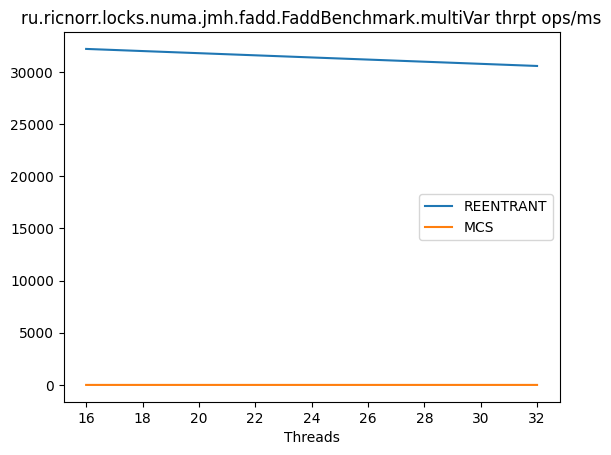

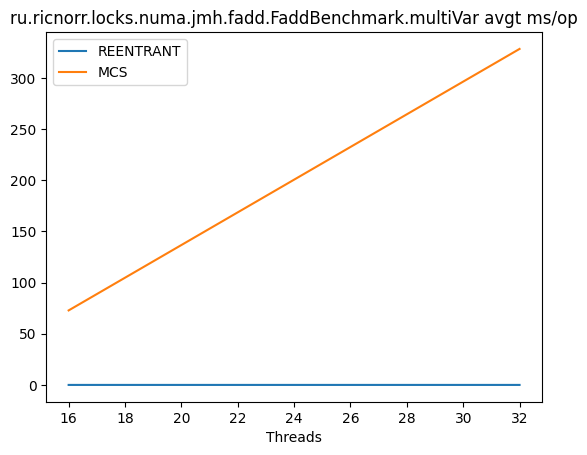

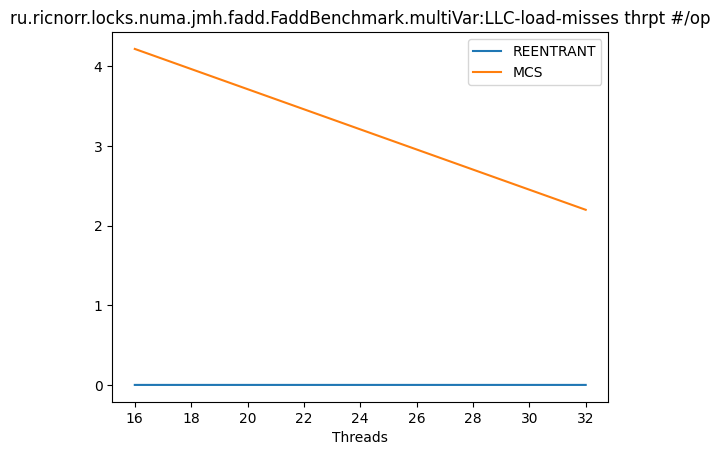

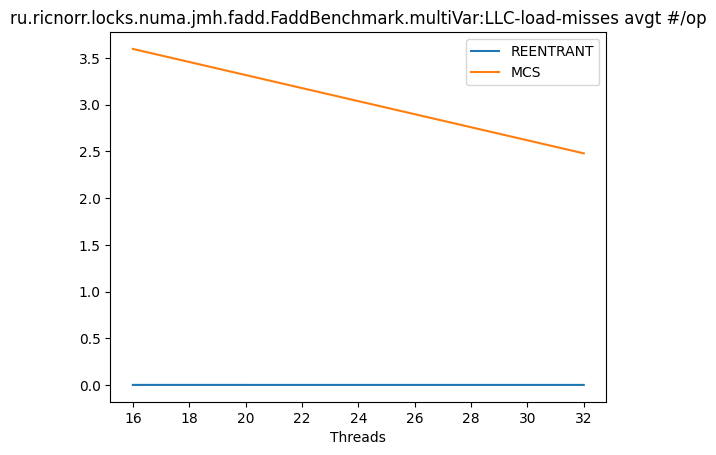

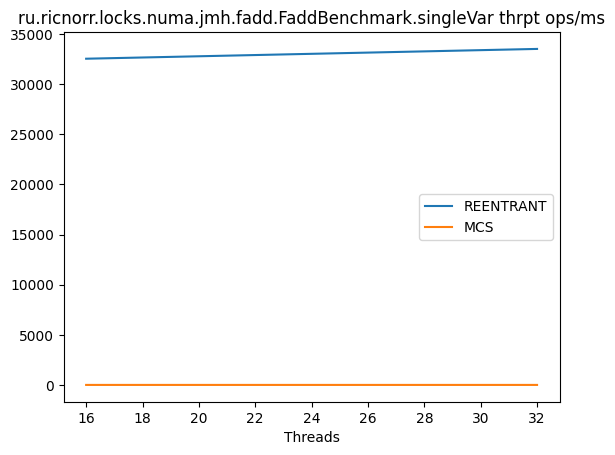

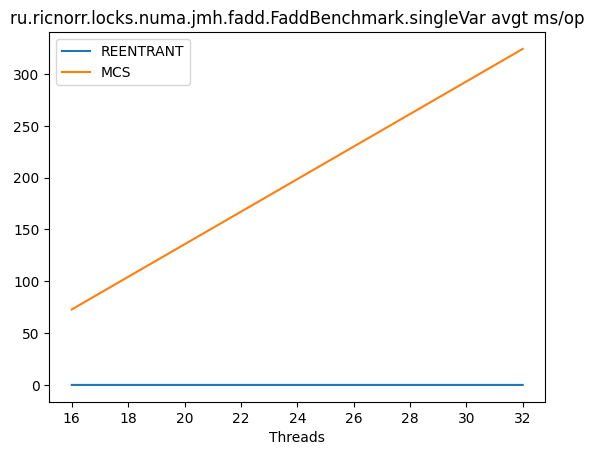

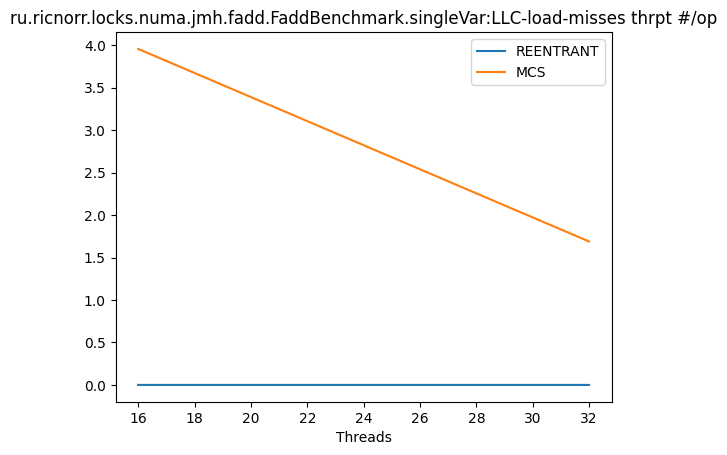

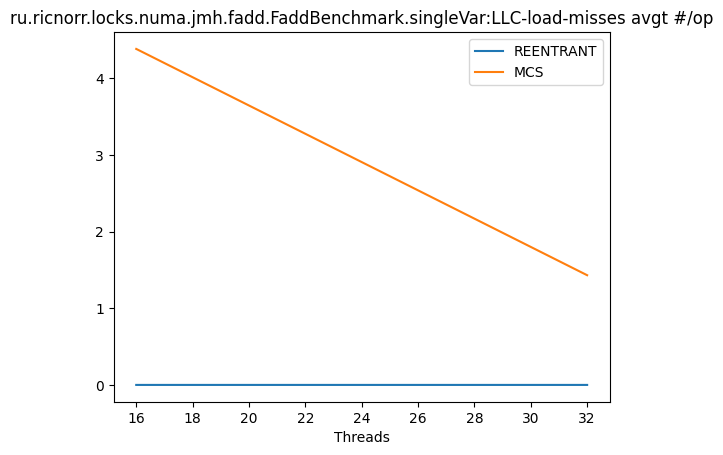

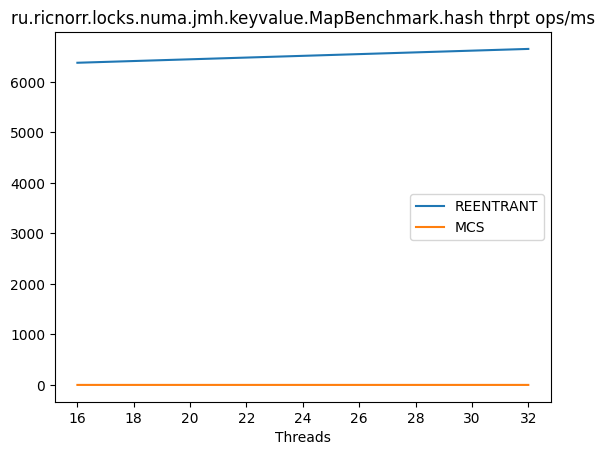

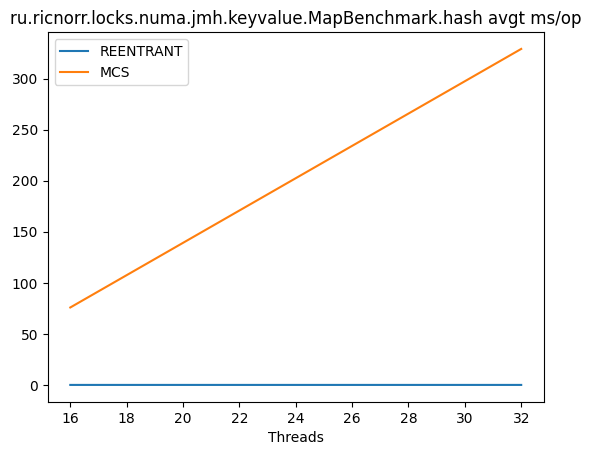

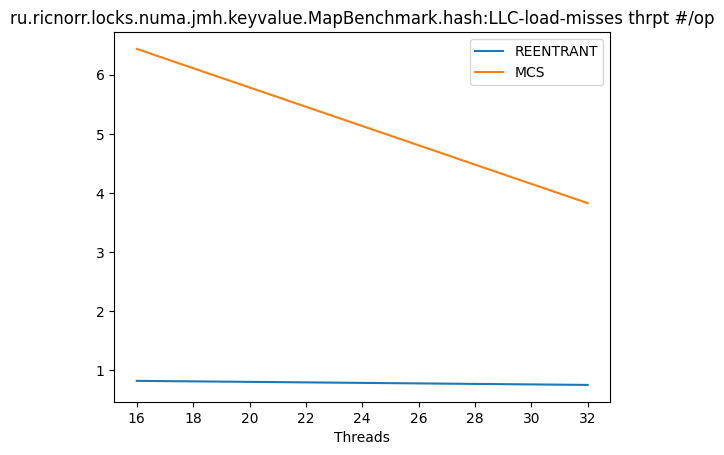

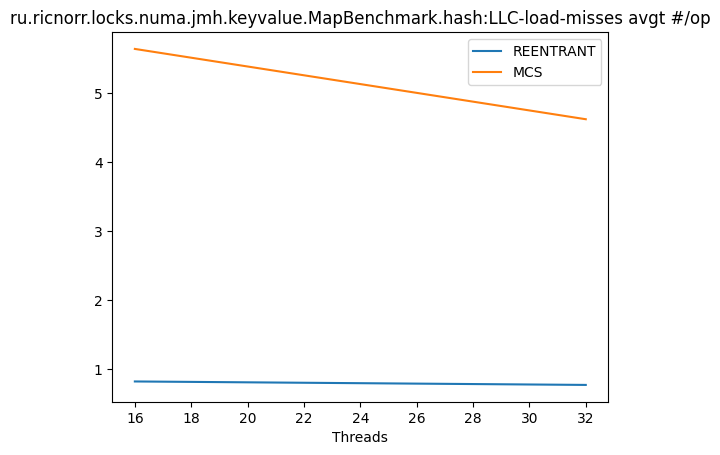

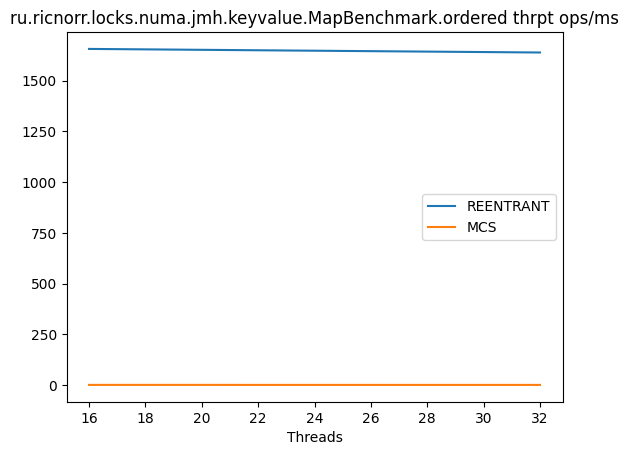

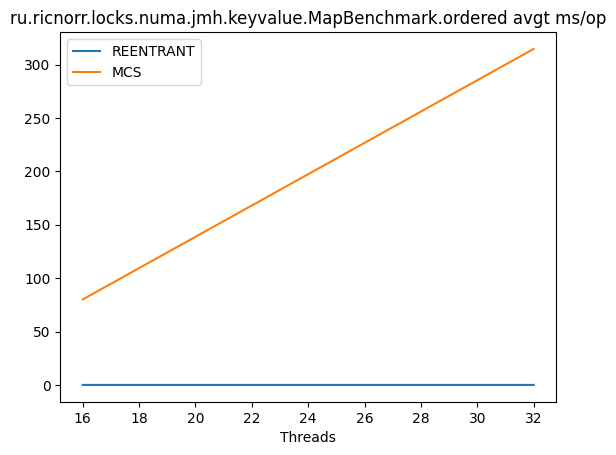

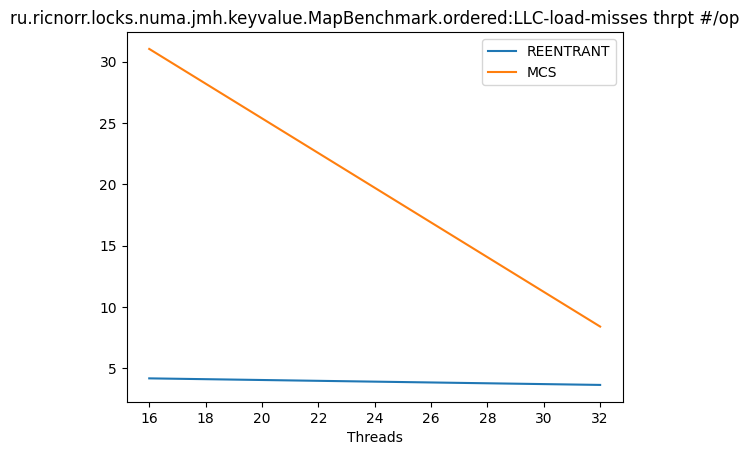

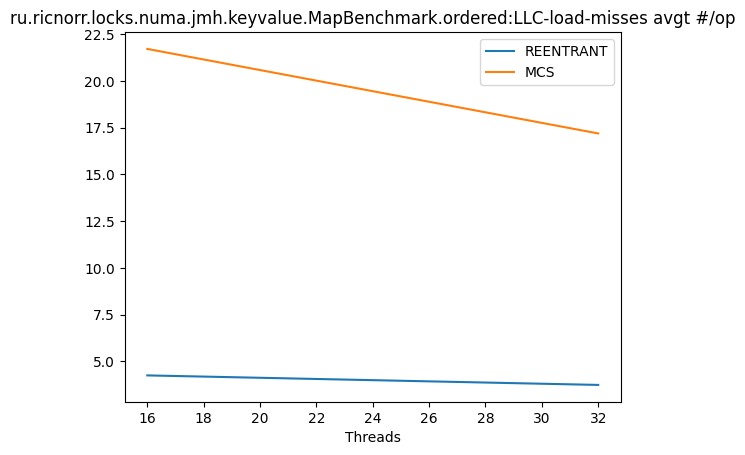

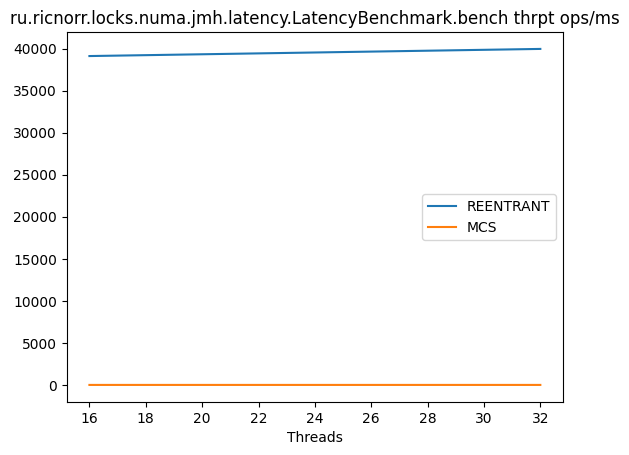

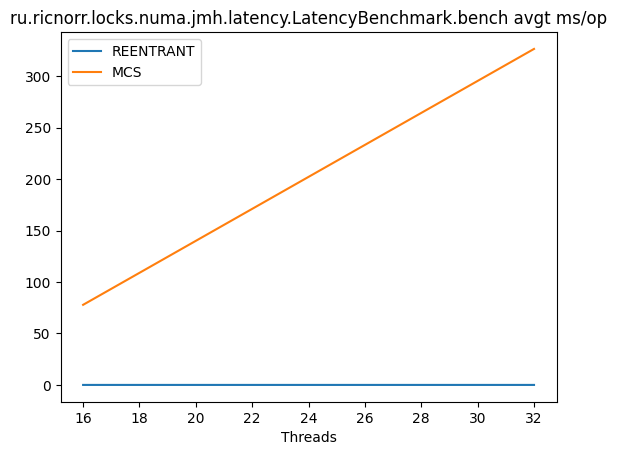

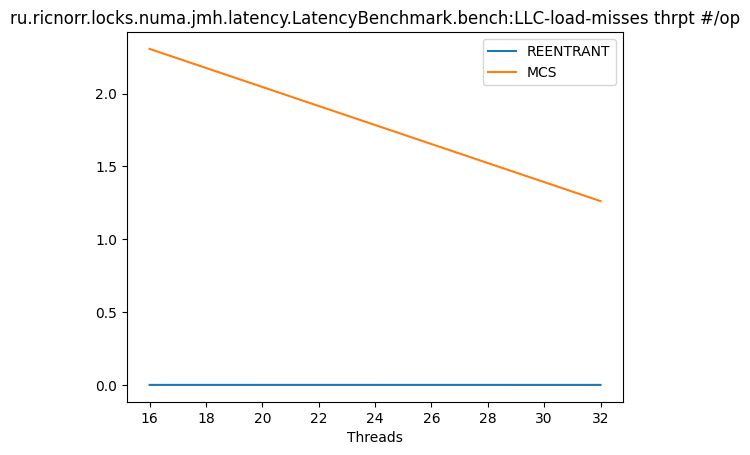

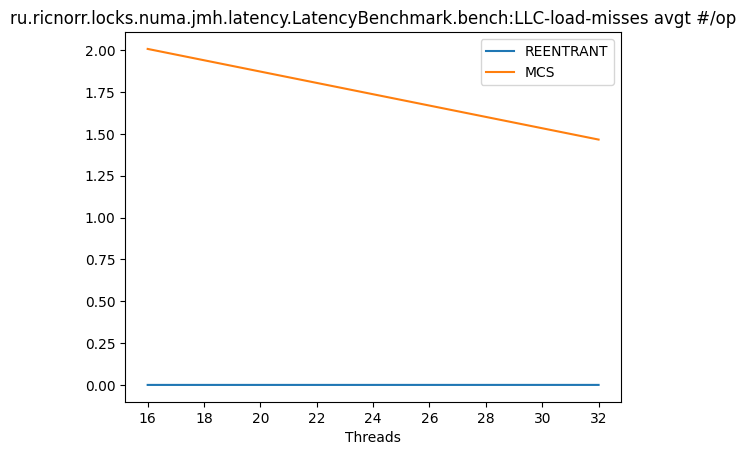

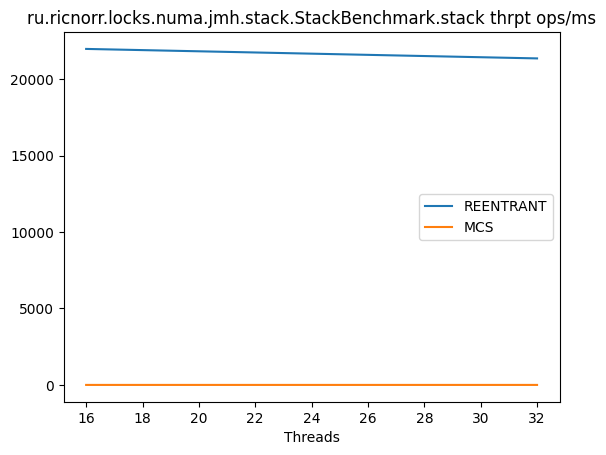

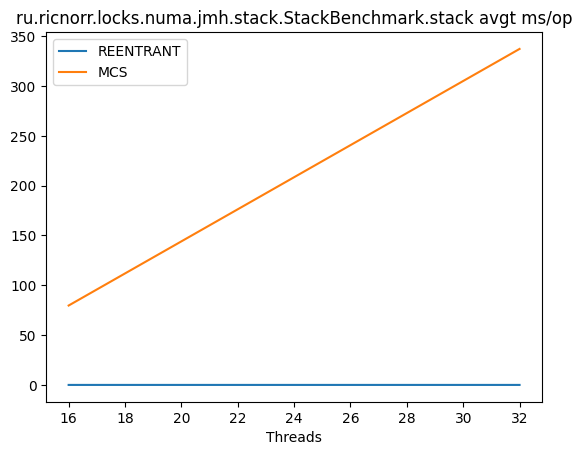

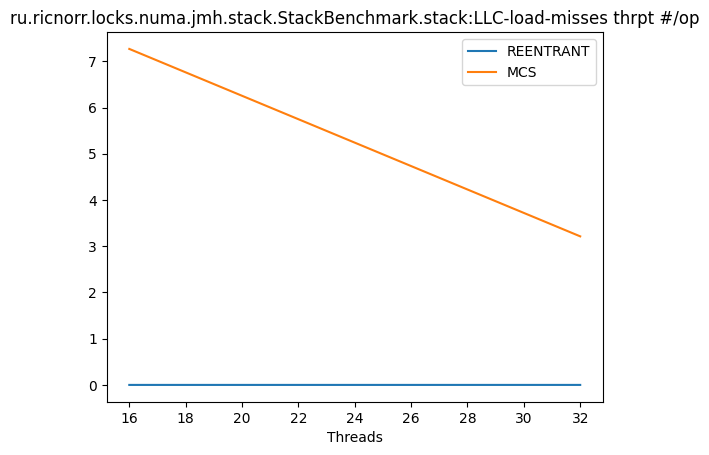

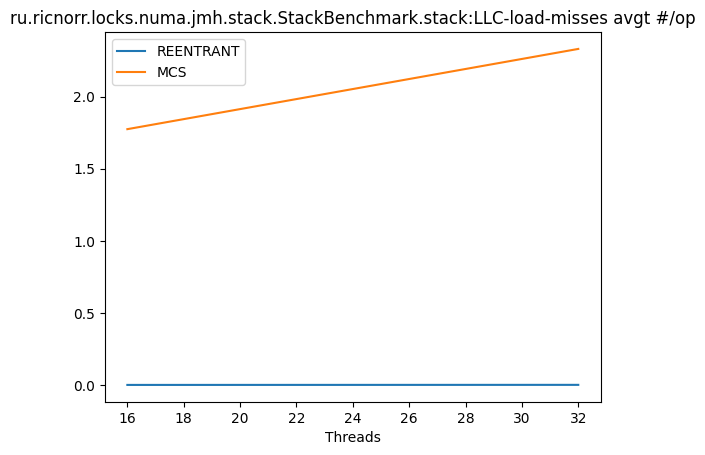

In [38]:
import matplotlib.pyplot as plt
import re
for benchmark in benchmarks:
    df_bench = df[df['Benchmark'] == benchmark]
    modes = set(df_bench['Mode'])
    for mode in modes:
        df_bench_mode = df_bench[df_bench['Mode'] == mode]
        ax = plt.axes(title = benchmark + ' ' + mode  + ' ' + df_bench_mode.iloc[0]['Unit'])
        #plot = plt.plot(title = benchmark + ' ' + mode + ' ' + df_bench_mode.iloc[0]['Unit'])
        locks = set(df_bench['Param: lockType'])
        for lock in locks:
            df_bench_lock = df_bench_mode[df_bench_mode['Param: lockType'] == lock]
            df_bench_lock.plot(ax=ax,x='Threads',y='Score',label=lock)
        plt.show()    